In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
from mplsoccer import VerticalPitch


In [104]:
df = pd.read_csv("data/efl_championship_shots_07022022-2.csv", index_col=0)
df = df[df["date"] >= "2021-08-06"].reset_index(drop=True)
df.rename(columns={"x": "y", "y": "x"}, inplace=True)

y_bins = [105] + [105 - 5.5*x for x in range(1, 10)]+[45]
x_bins = [68] + [68 - 6.8*x for x in range(1, 10)]+[0]

x_bins.sort()
y_bins.sort()

df["bins_x"] = pd.cut(df["x"], bins=x_bins)
df["bins_y"] = pd.cut(df["y"], bins=y_bins)

df_teams = (
    df.groupby(
        ["bins_x", "bins_y", "teamName", "teamId", "teamColor"],
        observed=True
    )["xGOT"].sum().reset_index()
)

df_teams = (
    df_teams.
    sort_values(by = ["bins_y", "bins_x"]).
    reset_index(drop = True)
)


In [105]:
example_df = df_teams[df_teams["teamName"]=="Luton Town"]
total_example = example_df["xGOT"].sum()

example_df=(
    example_df
    .assign(xGOT_share = lambda x: x.xGOT/total_example)
)

example_df=(
    example_df
    .assign(xGOT_scaled = lambda x: x.xGOT_share/x.xGOT_share.max())
)

In [106]:
def soc_pitch_divisions(ax, grids=False):
    pitch = VerticalPitch(
        pitch_type="uefa",
        half=True,
        goal_type='box',
        linewidth=1.25,
        line_color='black'
    )
    pitch.draw(ax=ax)

    if grids:
        y_lines = [105-5.5*x for x in range(1, 10)]
        x_lines = [68-6.8*x for x in range(1, 10)]

        for i in x_lines:
            ax.plot(
                [i, i], [45, 105],
                color="lightgray",
                ls="--",
                lw=.75,
                zorder=-1
            )
        for j in y_lines:
            ax.plot(
                [68, 0], [j, j],
                color="lightgray",
                ls="--",
                lw=.75,
                zorder=-1
            )

    return ax


In [107]:
def soc_xGOT_plot(ax, grids, teamId, data=df_teams):
    df = data.copy()
    df = data[data["teamId"] == teamId]
    total_xGOT = df["xGOT"].sum()

    df = (df.assign(xGOT_share=lambda x: x.xGOT/total_xGOT))
    df = (df.assign(xGOT_scaled=lambda x: x.xGOT_share/x.xGOT_share.max()))

    soc_pitch_divisions(ax, grids=grids)

    counter = 0
    for X, Y in zip(df["bins_x"], df["bins_y"]):
        ax.fill_between(
            x=[X.left, X.right],
            y1=Y.left,
            y2=Y.right,
            color="#495300",
            alpha=df["xGOT_scaled"].iloc[counter],
            zorder=-1,
            lw=0
        )

        if df['xGOT_share'].iloc[counter] > .02:
            text_ = ax.annotate(
                xy=(X.right - (X.right - X.left)/2,
                    Y.right - (Y.right - Y.left)/2),
                text=f"{df['xGOT_share'].iloc[counter]:.0%}",
                ha="center",
                va="center",
                color="black",
                size=6.5,
                weight="bold",
                zorder=3
            )

            text_.set_path_effects(
                [path_effects.Stroke(
                    linewidth=1.5, foreground="white"), path_effects.Normal()]
            )

        counter += 1

    return ax


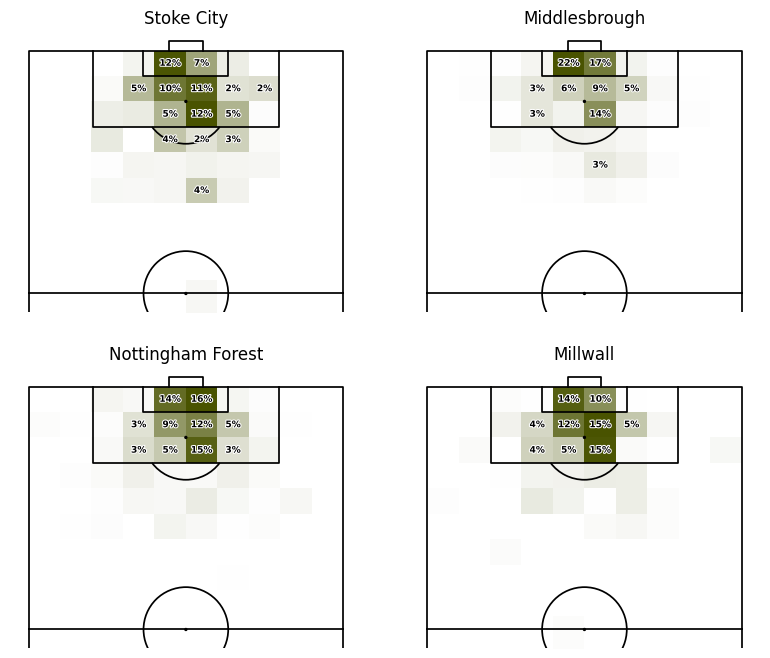

In [108]:
fig = plt.figure(figsize=(12, 8), dpi=100)

ax_1 = plt.subplot(221)
ax_2 = plt.subplot(222)
ax_3 = plt.subplot(223)
ax_4 = plt.subplot(224)


soc_xGOT_plot(ax_1, False, 10194, data = df_teams)
soc_xGOT_plot(ax_2, False, 8549, data = df_teams)
soc_xGOT_plot(ax_3, False, 10203, data = df_teams)
soc_xGOT_plot(ax_4, False, 10004, data = df_teams)

ax_1.set_title("Stoke City", loc = 'center')
ax_2.set_title("Middlesbrough", loc = 'center')
ax_3.set_title("Nottingham Forest", loc = 'center')
ax_4.set_title("Millwall", loc = 'center')

plt.subplots_adjust(wspace = -.25)